In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(readr)
  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
data <- prepare_OC_sc_spatial()
df <- data[[1]]
cell_annot <- data[[2]]
so_rna <- data[[3]]

In [3]:
base_dir <- CachePath('OC_scaled_dat6/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [4]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

Enrichment

In [5]:
markers <- load_markers_OC()

In [10]:
devtools::load_all()
devtools::load_all("~/segmentation-error-impact/cellAdmix/")

ℹ Loading cellAdmixNotebooks
ℹ Loading cellAdmix


In [11]:
enr_res <- run_enr_multi(
  all_nmf, markers, dir_save=base_dir, adj_pvals=TRUE, pthresh=.1, n_perm=1000,
  df=df, crf_h=40, n.cores=15
)

[1] "Running test 1 out of 5"
[1] "Running test 2 out of 5"
[1] "Running test 3 out of 5"
[1] "Running test 4 out of 5"
[1] "Running test 5 out of 5"


Enrichment end

In [12]:
# load saved enrichment results
enr_res_all <- file.path(base_dir, 'enrich_results.rds') %>% readRDS()

In [13]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(all_nmf,all_ctypes=all_ctypes,
                                       dir=base_dir,bridge_pthresh=.1,
                                       bridge_adj_pvals=FALSE)

In [14]:
# load and extract bridge results
memb_res_all <- extract_memb_multi(all_nmf,all_ctypes=all_ctypes,
                                   dir=base_dir,memb_pthresh=.01,
                                   memb_adj_pvals=FALSE)

In [12]:
fp_checks <- check_fp_multi(df,cell_annot,crf_all,enr_res_all=enr_res_all,
                            bridge_res_all=bridge_res_all,memb_res_all=memb_res_all,
                            do_clean=TRUE,knn_k=100,median_thresh=.2)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

In [16]:
# compute cell adj mat for scores calculation
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimateCellAdjacency(df_ct_match, random.shift=1e-2, n.cores=20)

In [15]:
# now to get genes to exclude
so_spatial <- get_counts_meta_seurat(df)
so_spatial <- NormalizeData(so_spatial)
common_genes <- intersect(rownames(so_rna), rownames(so_spatial))
length(common_genes)
so_spatial %<>% subset(features=common_genes)
so_rna %<>% subset(features=common_genes)
cor_cors <- estimateCorrelationPreservation(so_spatial[['RNA']]$data, so_rna[['RNA']]$data)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] 4912

In [16]:
dbl_score_params <- list(
  signal_thres=0.4,
  exclude_genes=names(cor_cors)[cor_cors<.5],
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=NULL,
  max.prob.high=0.1
)

In [17]:
# compute admixture probability scores
scores_final_df <- suppressWarnings(get_scores_multi(
  annot_res_all, orig_nms_all, dbl_score_params,
  df, so_rna, crf_all, cell_adj_df, n.cores=5
))

saveRDS(scores_final_df, file.path(base_dir, 'scores_final_df.rds'))

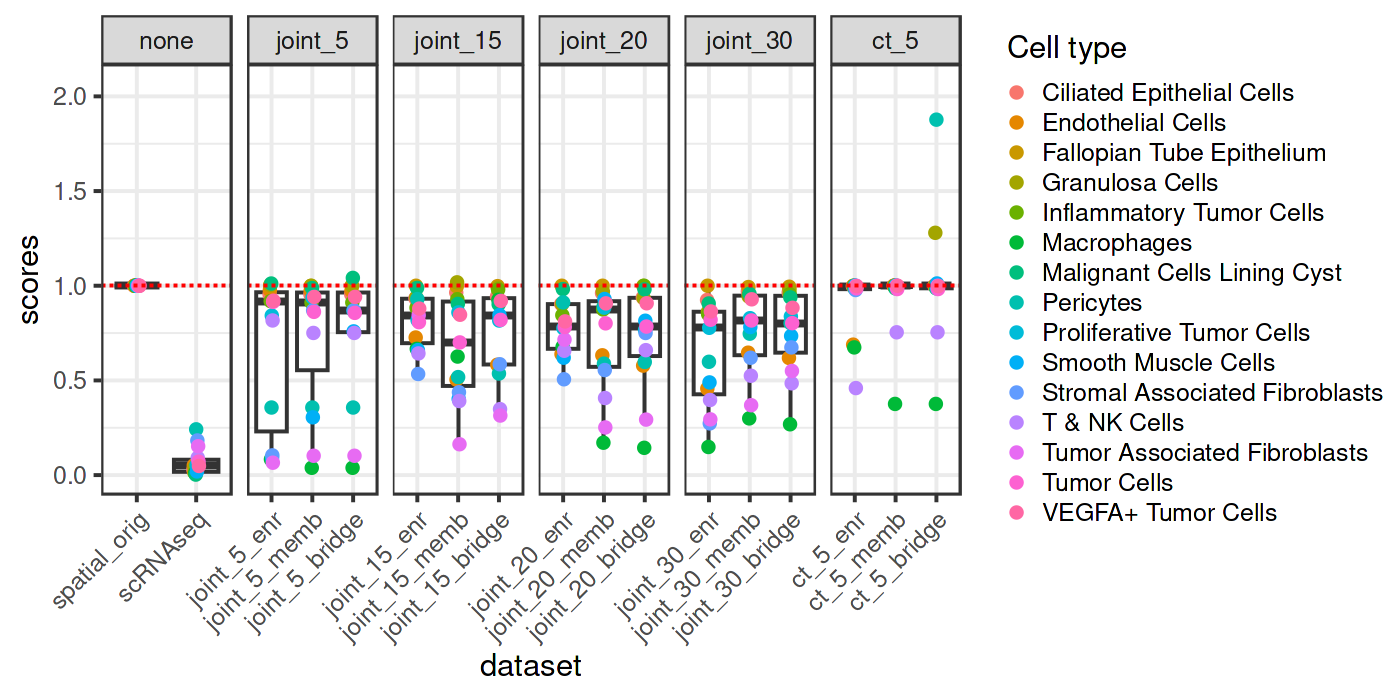

In [19]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)

p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.1,
                            min_mean_thresh = 1e-3,dodge.width=.1)
p

In [76]:
res_nm <- 'joint_20_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(scores_orig,scores_cln,f_rm,df,crf_res,
                                    upper_lim=1.5,min_mean_thresh=1e-3)

Picking joint bandwidth of 0.0445



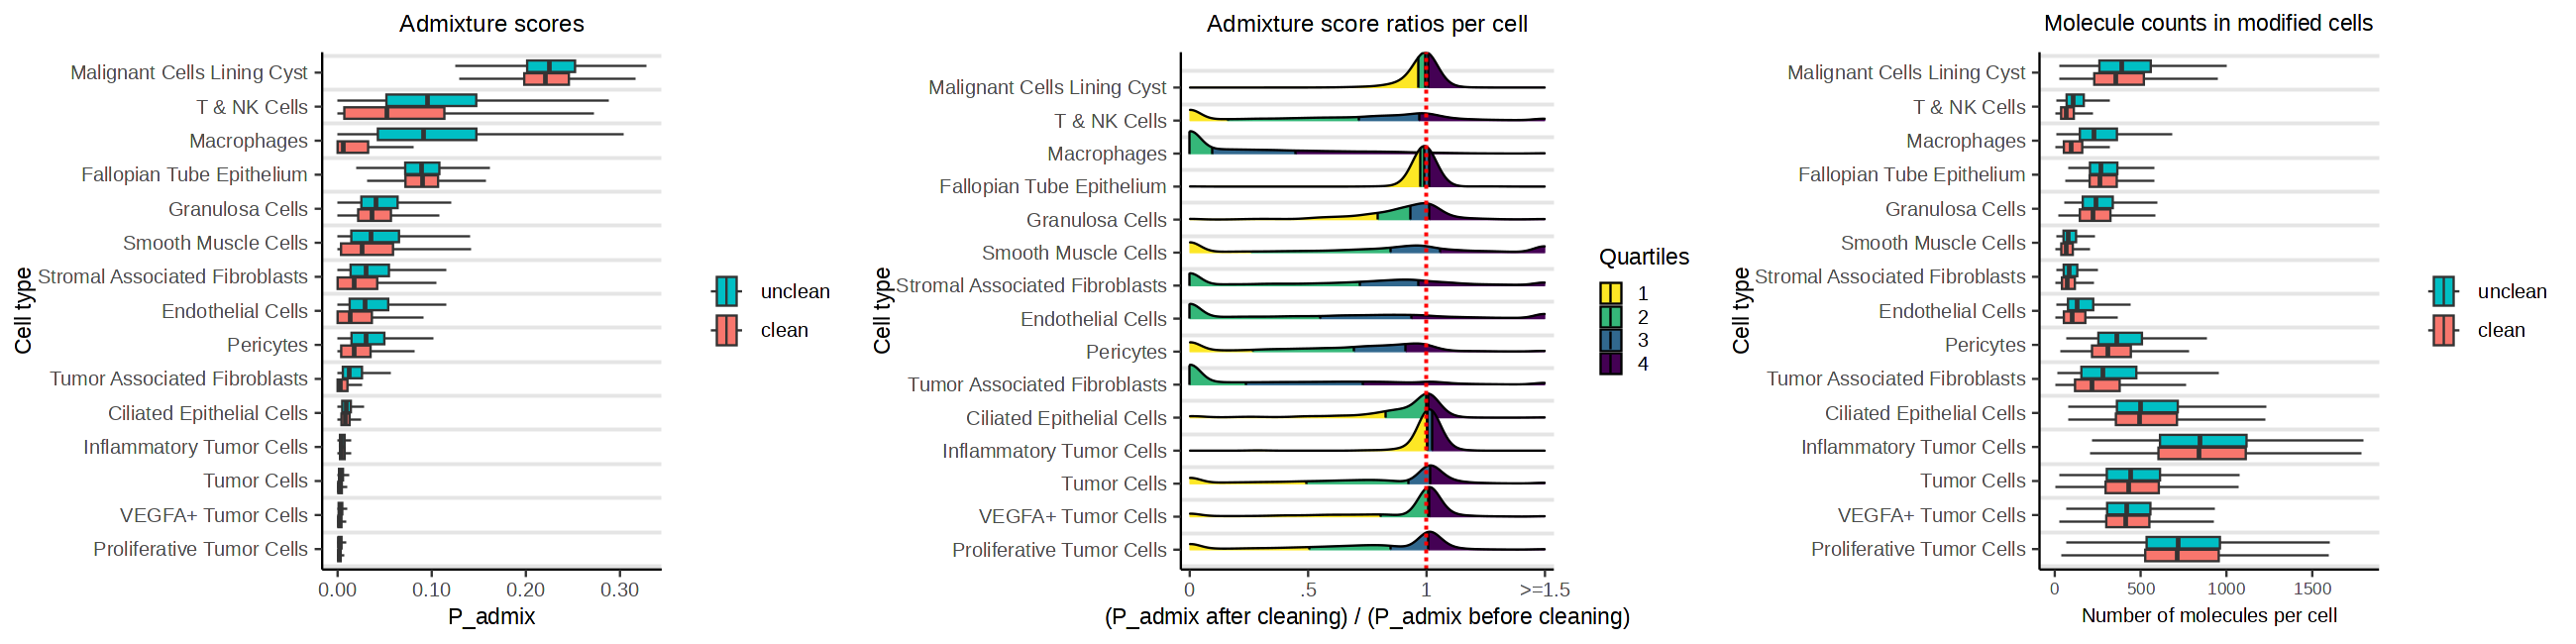

In [80]:
options(repr.plot.width = 13, repr.plot.height = 3.25, repr.plot.res = 200)
fig <- plot_grid(plotlist=plts[c(1,2,4)],nrow=1,align='h')
fig

In [81]:
pdf(OutputPath("oc_cell_score_ratios.pdf"), useDingbats=FALSE, width=13, height=3.25)
fig
dev.off()

png 
  2

In [88]:
saveRDS(plts[c(1,2,4)], CachePath("oc_cell_score_ratios2.rds"))

In [7]:
# saving an original counts version of the data
so_spatial_orig <- get_counts_meta_seurat(df,normalize=TRUE)
saveRDS(so_spatial_orig, file.path(base_dir, 'so_spatial_orig.rds'))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [10]:
# saving a cleaned counts version of the data
k <- 20
res_nm <- paste0('joint_',k,'_bridge')
f_rm <- annot_res_all[[res_nm]]
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]

# clean the df
df$factor <- crf_res[,1]
df_cln <- df[!(paste(df$factor, df$celltype, sep = "_") %in% f_rm), ]

# make and save a counts version of df_cln
so_spatial_cln <- get_counts_meta_seurat(df_cln,normalize=TRUE)
saveRDS(so_spatial_cln, paste0(base_dir, 'so_spatial_cln_',k,'_full.rds'))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
